# CNN para 33 actividades

## Separación de sets
Primero separamos los quaternions en sets de entrenamiento, validación y test:

In [1]:
import os as os

In [2]:
import tensorflow.keras as keras

In [3]:
# Módulos necesarios. Asegurarse de poder importarlos.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import sys
from six.moves import cPickle as pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import csv
from pylab import rcParams
from scipy import stats
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
tf.__version__

/usr/bin/python
3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


'1.14.0'

In [5]:
keras.__version__

'2.2.4-tf'

# Generación del dataset

Hacemos uso de los ficheros que contiene los cuaterniones separados por sujetos y actividad.

Definimos una serie de funciones para la lectura de los datos y finalmente realizamos el dataset (así leemos los datos en el entrenamiento "al vuelo").

In [6]:
# Ruta raíz
PATH = '../data_reset_def'

# Ruta de los ceckpoints
CKPATH = PATH + '/checkpoints'

quaturls = !ls -1 "{PATH}"

In [7]:
global activities
activities =  [19]
global subjects
subjects = [1,2,3,5,8,9,10,11,13,14,16,17]

In [8]:
quat_corr = []
for filename in quaturls:
    for activity in activities:
        if(int(filename[-6:-4])==activity):
            quat_corr.append(filename)

In [9]:
quat_def = []

i=0
for filename in quat_corr:
    for subject in subjects:
        if(int(quat_corr[i][8:10])==subject):
            quat_def.append(filename)
    i+=1

In [10]:
quaturls = quat_def

del quat_corr, quat_def

#print(quaturls)

### Separación por sujetos

In [12]:
# Shuffle de los datos
n = len(quaturls)

tr_urls = []
va_urls = []
ts_urls = []

i=0
for filename in quaturls:
    if(int(quaturls[i][8:10])==2 or int(quaturls[i][8:10])==10):
        va_urls.append(filename)
    elif(int(quaturls[i][8:10])==16):
        ts_urls.append(filename)
    else:
        tr_urls.append(filename)
    i+=1

print('Total files: ' + str(len(quaturls)))
print('Train files: ' + str(len(tr_urls)))
print('Validation files: ' + str(len(va_urls)))
print('Test files: ' + str(len(ts_urls)))

Total files: 12
Train files: 9
Validation files: 2
Test files: 1


In [13]:
tr_fullpath = [os.path.join(PATH,s) for s in tr_urls]
print('TRAINING: ')
print(tr_fullpath)
va_fullpath = [os.path.join(PATH,s) for s in va_urls]
print('VALIDATION: ')
print(va_fullpath)
ts_fullpath = [os.path.join(PATH,s) for s in ts_urls]
print('TEST: ')
print(ts_fullpath)

TRAINING: 
['../data_reset_def/subject_01_RESET_act_19.csv', '../data_reset_def/subject_03_RESET_act_19.csv', '../data_reset_def/subject_05_RESET_act_19.csv', '../data_reset_def/subject_08_RESET_act_19.csv', '../data_reset_def/subject_09_RESET_act_19.csv', '../data_reset_def/subject_11_RESET_act_19.csv', '../data_reset_def/subject_13_RESET_act_19.csv', '../data_reset_def/subject_14_RESET_act_19.csv', '../data_reset_def/subject_17_RESET_act_19.csv']
VALIDATION: 
['../data_reset_def/subject_02_RESET_act_19.csv', '../data_reset_def/subject_10_RESET_act_19.csv']
TEST: 
['../data_reset_def/subject_16_RESET_act_19.csv']


### Con listas y numpy (la más pesada de todas, pero seguros en que mantiene la estructura de los datos)

In [14]:
def sliding_window(df, n_time_steps, step, segments, labels, label, dim, train, n_channels):
    quat0 = df.iloc[:, 1:5][df['QUAT']=='quat0'].reset_index() # si no incluimos el reset_index(), al concatenarlos después
    quat1 = df.iloc[:, 1:5][df['QUAT']=='quat1'].reset_index() # aparecerá un dataframe de igual nº de filas que df, pero con
    quat2 = df.iloc[:, 1:5][df['QUAT']=='quat2'].reset_index() # NaN en las posiciones que no tienen número de cada dataframe quat,
    quat3 = df.iloc[:, 1:5][df['QUAT']=='quat3'].reset_index() # es decir, mantiene los índices de df.
    quat4 = df.iloc[:, 1:5][df['QUAT']=='quat4'].reset_index()
    #quat5 = df.iloc[:, 1:5][df['QUAT']=='quat5'].reset_index()
    #quat6 = df.iloc[:, 1:5][df['QUAT']=='quat6'].reset_index()
    #quat7 = df.iloc[:, 1:5][df['QUAT']=='quat7'].reset_index()
    #quat8 = df.iloc[:, 1:5][df['QUAT']=='quat8'].reset_index()
    
    quat = pd.concat([quat0.iloc[:, 1], quat0.iloc[:, 2], quat0.iloc[:, 3], quat0.iloc[:, 4],
                      quat1.iloc[:, 1], quat1.iloc[:, 2], quat1.iloc[:, 3], quat1.iloc[:, 4],
                      quat2.iloc[:, 1], quat2.iloc[:, 2], quat2.iloc[:, 3], quat2.iloc[:, 4],
                      quat3.iloc[:, 1], quat3.iloc[:, 2], quat3.iloc[:, 3], quat3.iloc[:, 4],
                      quat4.iloc[:, 1], quat4.iloc[:, 2], quat4.iloc[:, 3], quat4.iloc[:, 4]],
                      #quat5.iloc[:, 1], quat5.iloc[:, 2], quat5.iloc[:, 3], quat5.iloc[:, 4],
                      #quat6.iloc[:, 1], quat6.iloc[:, 2], quat6.iloc[:, 3], quat6.iloc[:, 4],
                      #quat7.iloc[:, 1], quat7.iloc[:, 2], quat7.iloc[:, 3], quat7.iloc[:, 4],
                      #quat8.iloc[:, 1], quat8.iloc[:, 2], quat8.iloc[:, 3], quat8.iloc[:, 4]],
                      axis = 1, keys = ['w0', 'x0', 'y0', 'z0', 'w1', 'x1', 'y1', 'z1', 'w2', 'x2', 'y2', 'z2', 
                                        'w3', 'x3', 'y3', 'z3', 'w4', 'x4', 'y4', 'z4']) #'w5', 'x5', 'y5', 'z5',
                                        #'w6', 'x6', 'y6', 'z6', 'w7', 'x7', 'y7', 'z7', 'w8', 'x8', 'y8', 'z8'])
    del quat0, quat1, quat2, quat3, quat4 #quat5, quat6, quat7, quat8
    
    if(train==False):
        step = n_time_steps
    
    if(n_channels == 1):
        for i in range(0, quat.shape[0] - n_time_steps, step): # Overlap
            # Con listas y numpy
            segments.append([])
            segments[dim].append(quat.iloc[i: i + n_time_steps, :].values) # Si distinguimos entre sensores
            labels.append(label-1)
            dim+=1
    else:
        n_columns = int(36/n_channels)
        for i in range(0, quat.shape[0] - n_time_steps, step):
            segments.append([])
            col = 0
            for j in range(n_channels):
                segments[dim].append([])
                segments[dim][j].append(quat.iloc[i:i+n_time_steps,col:col+n_columns].values)
                col+=n_columns
            labels.append(label-1)
            dim+=1
    
        
    del quat
    
    return segments, labels, dim

In [15]:
def load_quat(path, train, n_channels):

    n_time_steps, step = 1, 1  # n_time_steps/50 segundos de actividad y pasos de step/50 segundos (de overlap)
    
    # Con listas
    segments = []
    labels = []
    
    i=1
    dim = 0
    for filename in path:
        print("Reading %s (%d/%d)                                                   "%(filename, i, len(path)), end='\r')
        df = pd.read_csv(filename,sep=',')
        label = int(filename[-6:-4])
        for i in range(len(activities)):
            if(label==activities[i]):
                label=i+1
        
        segments, labels, dim = sliding_window(df, n_time_steps, step, segments, labels, label, dim, train, n_channels)
        
        i+=1
    
    del df
    
    return segments, labels


def load_train_quat(filename, n_channels):
    return load_quat(filename, True, n_channels)

def load_test_quat(filename, n_channels):
    return load_quat(filename, False, n_channels)


In [16]:
def get_dataset(data_path, batch_size, n_time_steps, train, valid, ds, n_channels):
    if(train):
        segments, labels = load_train_quat(data_path, n_channels)
    else:
        segments, labels = load_test_quat(data_path, n_channels)
    
    print('Generating the dataset                                                   ')                                              
    
    array = np.asarray(segments, dtype = 'float32')
    segments = np.reshape(array, (array.shape[0], n_channels, n_time_steps, int(20/n_channels)))
    array = np.asarray(labels, dtype = 'int8')
    labels = np.reshape(array, (array.shape[0], 1))
    
    del array
    
    # Map coninous dataset to categorical (One-Hot)
    labels = keras.utils.to_categorical(labels, 17)
    
    if(train):
        print('-'*20 + 'TRAIN' + '-'*20)
    elif(valid):
        print('-'*18 + 'VALIDATION' + '-'*12)
    else:
        print('-'*20 + 'TEST' + '-'*21)
    
    if(ds):
        dataset = tf.data.Dataset.from_tensor_slices((segments, labels))
    
        # It's necessary to repeat our data for all epochs
        dataset = dataset.batch(batch_size)
        
        dataset = dataset.shuffle(segments.shape[0])
        
        print('Dataset generated                                                        ')
        
        return dataset, segments, labels
    else:
        # Shuffle in the first dimension
        #permutation = np.arange(0,segments.shape[0]-1)
        #np.random.shuffle(permutation)
        #segments = segments[permutation]
        #labels = labels[permutation]
        print('Dataset generated                                                        ')
        
        return segments, labels

In [17]:
n_time_steps = 1
dataset = False # Set to True if you want a dataset or to False if you want np.arrays
batch_size = 1 # REAL batch_size
n_channels = 1 # It can be 1,4 or 9

if(dataset):
    train_dataset, tr_seg, tr_lab = get_dataset(tr_fullpath, ind, batch_size, n_time_steps, True, False, dataset, n_channels)
    valid_dataset, va_seg, va_lab = get_dataset(va_fullpath, ind, batch_size, n_time_steps, False, True, dataset, n_channels)
    test_dataset, ts_seg, ts_lab = get_dataset(ts_fullpath, ind, batch_size, n_time_steps, False, False, dataset, n_channels)
    
    print('Train dataset: ')
    print(train_dataset)
    print('Validation dataset: ')
    print(valid_dataset)
    print('Test dataset: ')
    print(test_dataset)
else:
    tr_seg, _ = get_dataset(tr_fullpath, batch_size, n_time_steps, True, False, dataset, n_channels)
    va_seg, _ = get_dataset(va_fullpath, batch_size, n_time_steps, False, True, dataset, n_channels)
    ts_seg, _ = get_dataset(ts_fullpath, batch_size, n_time_steps, False, False, dataset, n_channels)
    print('Train dataset: ')
    print(tr_seg.shape)
    print('Validation dataset: ')
    print(va_seg.shape)
    print('Test dataset: ')
    print(ts_seg.shape)

Generating the dataset                                                                                        
--------------------TRAIN--------------------
Dataset generated                                                        
Generating the dataset                                                                                        
------------------VALIDATION------------
Dataset generated                                                        
Generating the dataset                                                                                        
--------------------TEST---------------------
Dataset generated                                                        
Train dataset: 
(10927, 1, 1, 20)
Validation dataset: 
(2222, 1, 1, 20)
Test dataset: 
(1050, 1, 1, 20)


In [18]:
tr_seg = np.reshape(tr_seg,(tr_seg.shape[0],tr_seg.shape[2],tr_seg.shape[3]))
va_seg = np.reshape(va_seg,(va_seg.shape[0],va_seg.shape[2],va_seg.shape[3]))
ts_seg = np.reshape(ts_seg,(ts_seg.shape[0],ts_seg.shape[2],ts_seg.shape[3]))

In [19]:
print('Train dataset: ')
print(tr_seg.shape)
print('Validation dataset: ')
print(va_seg.shape)
print('Test dataset: ')
print(ts_seg.shape)

Train dataset: 
(10927, 1, 20)
Validation dataset: 
(2222, 1, 20)
Test dataset: 
(1050, 1, 20)


In [20]:
tr_seg = np.reshape(tr_seg,(tr_seg.shape[0],tr_seg.shape[2]))
va_seg = np.reshape(va_seg,(va_seg.shape[0],va_seg.shape[2]))
ts_seg = np.reshape(ts_seg,(ts_seg.shape[0],ts_seg.shape[2]))

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
tr_seg = scaler.fit_transform(tr_seg)
va_seg = scaler.fit_transform(va_seg)
ts_seg = scaler.fit_transform(ts_seg)

In [22]:
tr_seg = np.reshape(tr_seg,(tr_seg.shape[0], 1, tr_seg.shape[1]))
va_seg = np.reshape(va_seg,(va_seg.shape[0], 1, va_seg.shape[1]))
ts_seg = np.reshape(ts_seg,(ts_seg.shape[0], 1, ts_seg.shape[1]))

In [23]:
def create_y(seg):
    Y = []
    for i in range(1, seg.shape[0]):
        Y.append(seg[i,0,:])
    return np.array(Y)

In [24]:
trainX = np.reshape(tr_seg[:-1],(tr_seg.shape[0]-1, tr_seg.shape[1], tr_seg.shape[2]))
#trainY = np.reshape(tr_seg[1:],(tr_seg.shape[0]-1, tr_seg.shape[1], tr_seg.shape[2]))
trainY = create_y(tr_seg)

validX = np.reshape(va_seg[:-1],(va_seg.shape[0]-1, va_seg.shape[1], va_seg.shape[2]))
#validY = np.reshape(va_seg[1:],(va_seg.shape[0]-1, va_seg.shape[1], va_seg.shape[2]))
validY = create_y(va_seg)

testX = np.reshape(ts_seg[:-1],(ts_seg.shape[0]-1, ts_seg.shape[1], ts_seg.shape[2]))
#testY = np.reshape(ts_seg[1:],(ts_seg.shape[0]-1, ts_seg.shape[1], ts_seg.shape[2]))
testY = create_y(ts_seg)

In [25]:
print(trainX.shape, trainY.shape)
print(validX.shape, validY.shape)
print(testX.shape, testY.shape)

(10926, 1, 20) (10926, 20)
(2221, 1, 20) (2221, 20)
(1049, 1, 20) (1049, 20)


In [26]:
print(trainX[1])
print(trainY[0])

[[0.03213006 0.5755148  0.07074335 0.29704988 0.15412912 0.8785968
  0.50078833 0.3276651  0.13070309 0.8118694  0.54035205 0.401704
  0.34697625 0.60212797 0.808611   0.87900615 0.83248734 0.30239835
  0.2578796  0.2831363 ]]
[0.03213006 0.5755148  0.07074335 0.29704988 0.15412912 0.8785968
 0.50078833 0.3276651  0.13070309 0.8118694  0.54035205 0.401704
 0.34697625 0.60212797 0.808611   0.87900615 0.83248734 0.30239835
 0.2578796  0.2831363 ]


## Red

### Hiper parámetros

Definimos una serie de hiper parámetros aquí para tenerlos en una misma celda:

In [27]:
# Ajustado a los datos
n_time_steps = n_time_steps
n_channels = n_channels # Nº de canales
n_columns = int(20/n_channels)

# Podríamos variarlo
batch_size =1# Tamaño del batch
learning_rate = 1e-4 # Learning rate (por defecto es 0.001)
epochs = 500 # Épocas

### Modelo

In [28]:
from tensorflow.keras.initializers import RandomNormal

quat_input = keras.Input(shape=(n_time_steps, n_columns), name='input_layer')

units_1 = 100
units_2 = 10*128

gru_1 = keras.layers.GRU(units_1, activation='tanh', dropout=0.0, recurrent_dropout=0.0, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
                         recurrent_activation='tanh', return_sequences=False, reset_after=True)(quat_input)
'''
gru_2 = keras.layers.GRU(units_2, activation='sigmoid', dropout=0.0, recurrent_dropout=0.0, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02),
                         recurrent_activation='sigmoid', return_sequences=False, reset_after=True)(gru_1)

gru_3 = keras.layers.GRU(units, activation='sigmoid', dropout=0.0, recurrent_dropout=0.0, 
                         recurrent_activation='sigmoid', reset_after=True)(gru_2)
'''
# Output layers: separate outputs for the weather and the ground labels
multiclass_output = keras.layers.Dense(n_columns,name='predicted_data')(gru_1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
# Creamos la estrcutura que contendrá a nuestro modelo
model = keras.Model(inputs=quat_input, outputs=[multiclass_output])

# Compilamos el modelo
#model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, clipnorm=0.1, beta_1=0.9, beta_2=0.999), loss='mean_squared_error', metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.RMSprop(lr=learning_rate), loss='mean_squared_error', metrics=['accuracy'])

In [30]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 20)]           0         
_________________________________________________________________
gru (GRU)                    (None, 100)               36600     
_________________________________________________________________
predicted_data (Dense)       (None, 20)                2020      
Total params: 38,620
Trainable params: 38,620
Non-trainable params: 0
_________________________________________________________________
None


### Callbacks

In [31]:
from time import time

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-9, verbose=1, mode='min')
#reduce_lr = keras.callbacks.LearningRateScheduler(schedule)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [32]:
callbacks_list = [reduce_lr, early_stopping] #[checkpoint, tensorboard, csv_logger, reduce_lr, early_stopping]

### Entrenamiento

In [33]:
##### Lo entrenamos
if(dataset):
    history = model.fit(train_dataset,
                        epochs = epochs,
                        steps_per_epoch=None,
                        verbose = 1,
                        callbacks = callbacks_list,
                        validation_data =valid_dataset,
                        validation_steps = None)
    #model.save('./CNN_5.h5')
else:
    history = model.fit(trainX,
                        trainY,
                        epochs = epochs,
                        steps_per_epoch = None,
                        verbose = 1,
                        batch_size = batch_size,
                        callbacks = callbacks_list,
                        validation_data = (validX, validY), 
                        validation_steps = None)
    #model.save('./CNN_5.h5')

Train on 10926 samples, validate on 2221 samples
Epoch 1/500
10926/10926 [==============================] - 62s 6ms/sample - loss: 0.0093 - acc: 0.5705 - val_loss: 0.0209 - val_acc: 0.4313
Epoch 2/500
10926/10926 [==============================] - 61s 6ms/sample - loss: 4.5856e-04 - acc: 0.7815 - val_loss: 0.0148 - val_acc: 0.4773
Epoch 3/500
10926/10926 [==============================] - 61s 6ms/sample - loss: 3.7714e-04 - acc: 0.8129 - val_loss: 0.0116 - val_acc: 0.5065
Epoch 4/500
10926/10926 [==============================] - 61s 6ms/sample - loss: 3.5458e-04 - acc: 0.8198 - val_loss: 0.0096 - val_acc: 0.4782
Epoch 5/500
10926/10926 [==============================] - 61s 6ms/sample - loss: 3.4381e-04 - acc: 0.8325 - val_loss: 0.0085 - val_acc: 0.4849
Epoch 6/500
10926/10926 [==============================] - 61s 6ms/sample - loss: 3.3822e-04 - acc: 0.8337 - val_loss: 0.0074 - val_acc: 0.4813
Epoch 7/500
10926/10926 [==============================] - 61s 6ms/sample - loss: 3.3423e-0

KeyboardInterrupt: 

In [34]:
#Visualize training evolution
def plot_curves(model, acc, loss, val_acc, val_loss):
    #########################################################################################
    # LOSS plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[loss], label='Training loss')
    plt.plot(model.history.history[val_loss], label='Validation loss')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Loss in trainnig', fontsize=20)
    fig = plt.gcf()
    plt.show()
    
    fig.savefig('./00_06z_models/loss_train_00_06z.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./00_06z_models/loss_train_00_06z.svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[acc], label='Training accuracy')
    plt.plot(model.history.history[val_acc], label= 'Validation accuracy')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Accuracy in training', fontsize=20)
    fig = plt.gcf()
    plt.show()

    fig.savefig('./00_06z_models/acc_train_00_06z.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./00_06z_models/acc_train_00_06z.svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC+LOSS plot
    plt.figure(figsize=(14,10))
    plt_loss = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    plt_acc = plt_loss.twinx()
    plt_acc.axis["right"].toggle(all=True)
    
    plt_loss.set_xlim(0, len(model.history.history[loss]))
    plt_loss.set_ylim(0, max(model.history.history[loss]))
    plt_loss.set_xlabel('Epochs')
    plt_loss.set_ylabel('Loss')
    plt_acc.set_ylabel('Accuracy')
                        
    plt_loss.axis['left'].label.set_fontsize(15)
    plt_loss.axis['bottom'].label.set_fontsize(15)
    plt_acc.axis['right'].label.set_fontsize(15)
    
    plt_loss.plot(model.history.history[loss], c='tab:blue', ls='--', label='Training loss')
    plt_acc.plot(model.history.history[acc], c='tab:orange',ls='--', label='Training accuracy')
    plt_loss.plot(model.history.history[val_loss], c='tab:blue',ls='-', label='Validation loss')
    plt_acc.plot(model.history.history[val_acc], c='tab:orange',ls='-', label='Validation accuracy')
    
    plt.tick_params(labelsize=10)
    plt.title('Training performance', fontsize=20)
    plt_acc.set_ylim(0, 1)
    plt_loss.legend(loc=1, prop={'size': 10})
    
    fig = plt.gcf()
    plt.show()

    fig.savefig('./00_06z_models/all_train_00_06z.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./00_06z_models/all_train_00_06z.svg', bbox_inches='tight',format='svg')

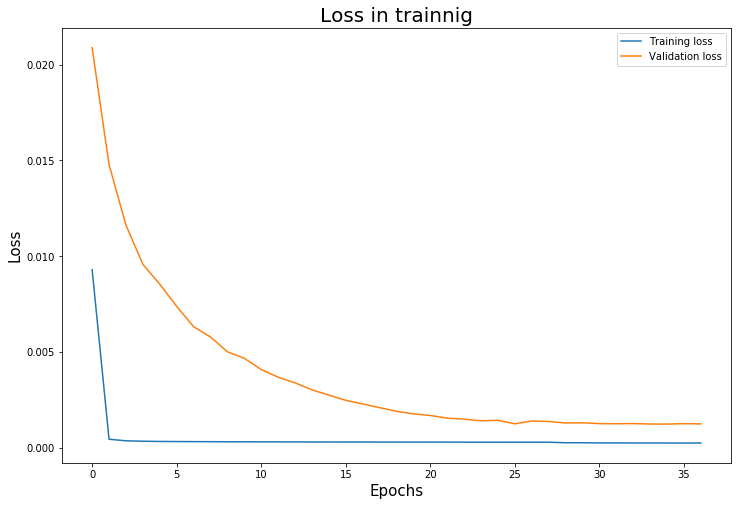

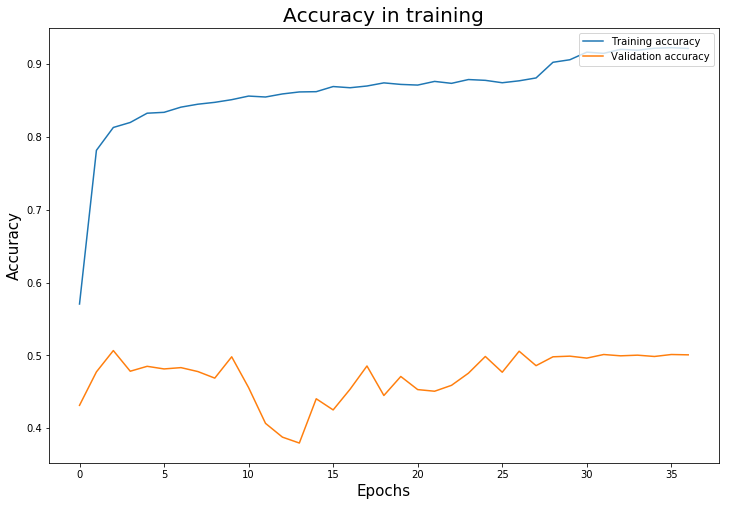

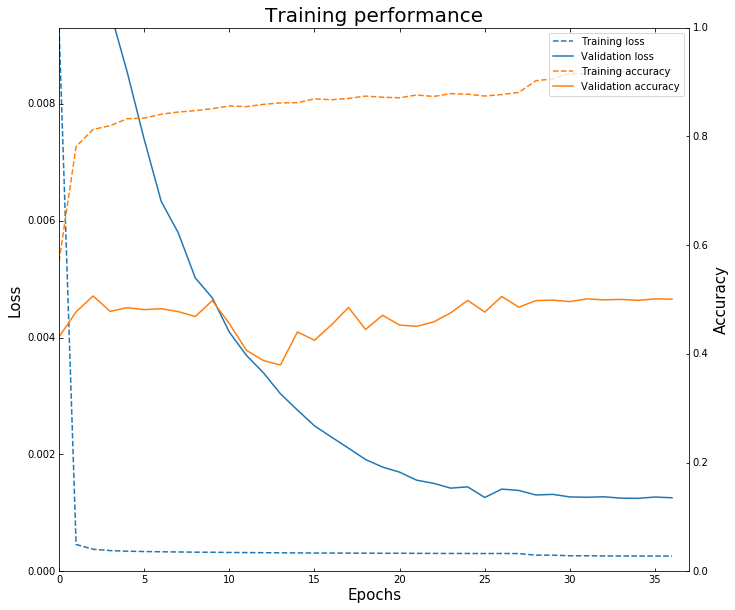

In [35]:
#Visualize training evolution
plot_curves(model, 'acc', 'loss', 'val_acc', 'val_loss')

### Test

In [36]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#trainPredict = np.reshape(trainPredict,(trainPredict.shape[0]*trainPredict.shape[1], trainPredict.shape[2]))
#testPredict = np.reshape(testPredict,(testPredict.shape[0]*testPredict.shape[1], testPredict.shape[2]))

trainY = np.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
testY = np.reshape(testY,(testY.shape[0],testY.shape[1]))

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print(trainPredict.shape)
print(testPredict.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

(10926, 20)
(1049, 20)
Train Score: 0.01 RMSE
Test Score: 0.03 RMSE


### Lo escribimos a fichero

In [37]:
def write(name, ts_seg):
    fo = open(name, "w")
    head = "QUAT,w,x,y,z,timestamp\n"
    fo.seek(0,2)
    fo.write(head)
    fo.close()
    
    fo = open(name, "a")
    #salida = np.reshape(ts_seg, (ts_seg.shape[0]*ts_seg.shape[2], ts_seg.shape[3]))
    salida = ts_seg
    
    k = 0
    for i in range(salida.shape[0]):
        if(i%128==0):
            if(i!=0):
                k+=1
        print('%d'%(i), end='\r')
        fo.write("quat0,"+str(salida[i][0])+","+str(salida[i][1])+","+str(salida[i][2])+","+str(salida[i][3])+","+str(i)+","+'\n')
        fo.write("quat1,"+str(salida[i][4])+","+str(salida[i][5])+","+str(salida[i][6])+","+str(salida[i][7])+","+str(i)+","+'\n')
        fo.write("quat2,"+str(salida[i][8])+","+str(salida[i][9])+","+str(salida[i][10])+","+str(salida[i][11])+","+str(i)+","+'\n')
        fo.write("quat3,"+str(salida[i][12])+","+str(salida[i][13])+","+str(salida[i][14])+","+str(salida[i][15])+","+str(i)+","+'\n')
        fo.write("quat4,"+str(salida[i][16])+","+str(salida[i][17])+","+str(salida[i][18])+","+str(salida[i][19])+","+str(i)+","+'\n')
        if(salida.shape[1]==36):
            fo.write("quat5,"+str(salida[i][20])+","+str(salida[i][21])+","+str(salida[i][22])+","+str(salida[i][23])+","+str(i)+","+'\n')
            fo.write("quat6,"+str(salida[i][24])+","+str(salida[i][25])+","+str(salida[i][26])+","+str(salida[i][27])+","+str(i)+","+'\n')
            fo.write("quat7,"+str(salida[i][28])+","+str(salida[i][29])+","+str(salida[i][30])+","+str(salida[i][31])+","+str(i)+","+'\n')
            fo.write("quat8,"+str(salida[i][32])+","+str(salida[i][33])+","+str(salida[i][34])+","+str(salida[i][35])+","+str(i)+","+'\n')
        else:
            fo.write("quat5,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
            fo.write("quat6,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
            fo.write("quat7,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
            fo.write("quat8,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
    fo.close()

In [38]:
name = "./00_06z_models/RESULT_PRED_00_06z.csv"
write(name, testPredict)

In [39]:
name = "./00_06z_models/RESULT_PASS_00_06z.csv"
passed =  np.reshape(testX,(testX.shape[0]*testX.shape[1],testX.shape[2]))
passed = scaler.inverse_transform(passed)
write(name,passed)

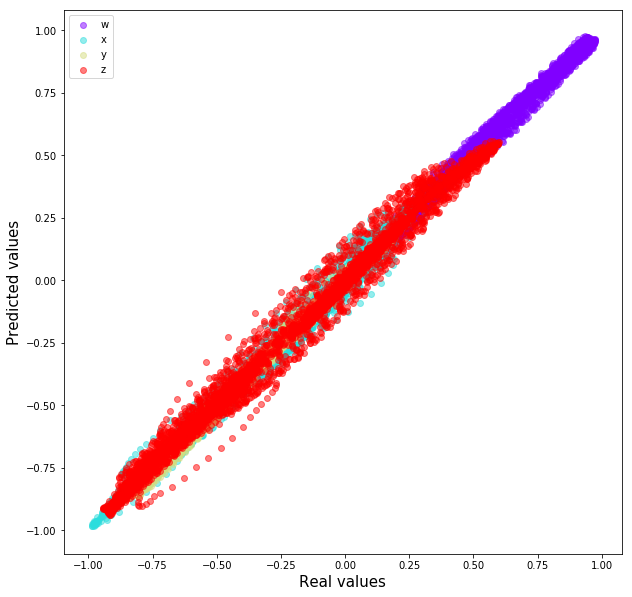

In [40]:
import matplotlib.cm as cm
plotX = np.concatenate((testY[:,0:4],testY[:,4:8]))
plotY = np.concatenate((testPredict[:,0:4],testPredict[:,4:8]))
for i in range(8,testY.shape[1],4):
    plotX = np.concatenate((plotX,testY[:,i:i+4]))
    plotY = np.concatenate((plotY,testPredict[:,i:i+4]))

labels = ['w', 'x', 'y', 'z']
colors = cm.rainbow(np.linspace(0, 1, len(plotX.T)))
plt.figure(figsize=(10,10))
for x, y, c, l in zip(plotX.T, plotY.T, colors, labels):
    plt.scatter(x, y, color=c, alpha=0.5, label=l)

plt.xlabel('Real values', fontsize=15)
plt.ylabel('Predicted values', fontsize=15)
plt.legend()

In [41]:
sensors = ['BACK', 'RUA', 'RLA', 'LUA', 'LLA']
print(sensors)

['BACK', 'RUA', 'RLA', 'LUA', 'LLA']


In [42]:
def plot_results(testY, testPredict,name):
    
    colorsX=['r--','g--','b--','y--']
    #colorsY=['tab:red','tab:green','tab:blue','tab:gray']
    colorsY=['r','g','b','y']

    j=0
    for i in range(0,testY.shape[1],4):
        plt.figure()
        plt.figure(figsize=(30,10))
        plt.plot(np.arange(0,testY.shape[0]), testY[:,i],colorsX[0], markersize=1, label='Real W')
        plt.plot(np.arange(0,testPredict.shape[0]),testPredict[:,i], colorsY[0], label='Predicted W')
        plt.plot(np.arange(0,testY.shape[0]), testY[:,i+1],colorsX[1], markersize=1, label='Real X')
        plt.plot(np.arange(0,testPredict.shape[0]),testPredict[:,i+1], colorsY[1], label='Predicted X')
        plt.plot(np.arange(0,testY.shape[0]), testY[:,i+2],colorsX[2], markersize=1, label='Real Y')
        plt.plot(np.arange(0,testPredict.shape[0]),testPredict[:,i+2], colorsY[2], label='Predicted Y')
        plt.plot(np.arange(0,testY.shape[0]), testY[:,i+3],colorsX[3], markersize=1, label='Real Z')
        plt.plot(np.arange(0,testPredict.shape[0]),testPredict[:,i+3], colorsY[3], label='Predicted Z')
        plt.xlabel('Samples', fontsize=20)
        plt.ylabel('Values', fontsize=20)
        plt.tick_params(labelsize=20)
        plt.legend(prop={'size': 10})
        plt.title('Real vs. Predicted values in %s'%(sensors[j]), fontsize=20)
        fig1 = plt.gcf()
        plt.show()

        fig1.savefig('./00_06z_models/'+name+'_%s_00_06z.pdf'%(sensors[j]), bbox_inches='tight',format='pdf')
        fig1.savefig('./00_06z_models/'+name+'_%s_00_06z.svg'%(sensors[j]), bbox_inches='tight',format='svg')

        j+=1

<Figure size 432x288 with 0 Axes>

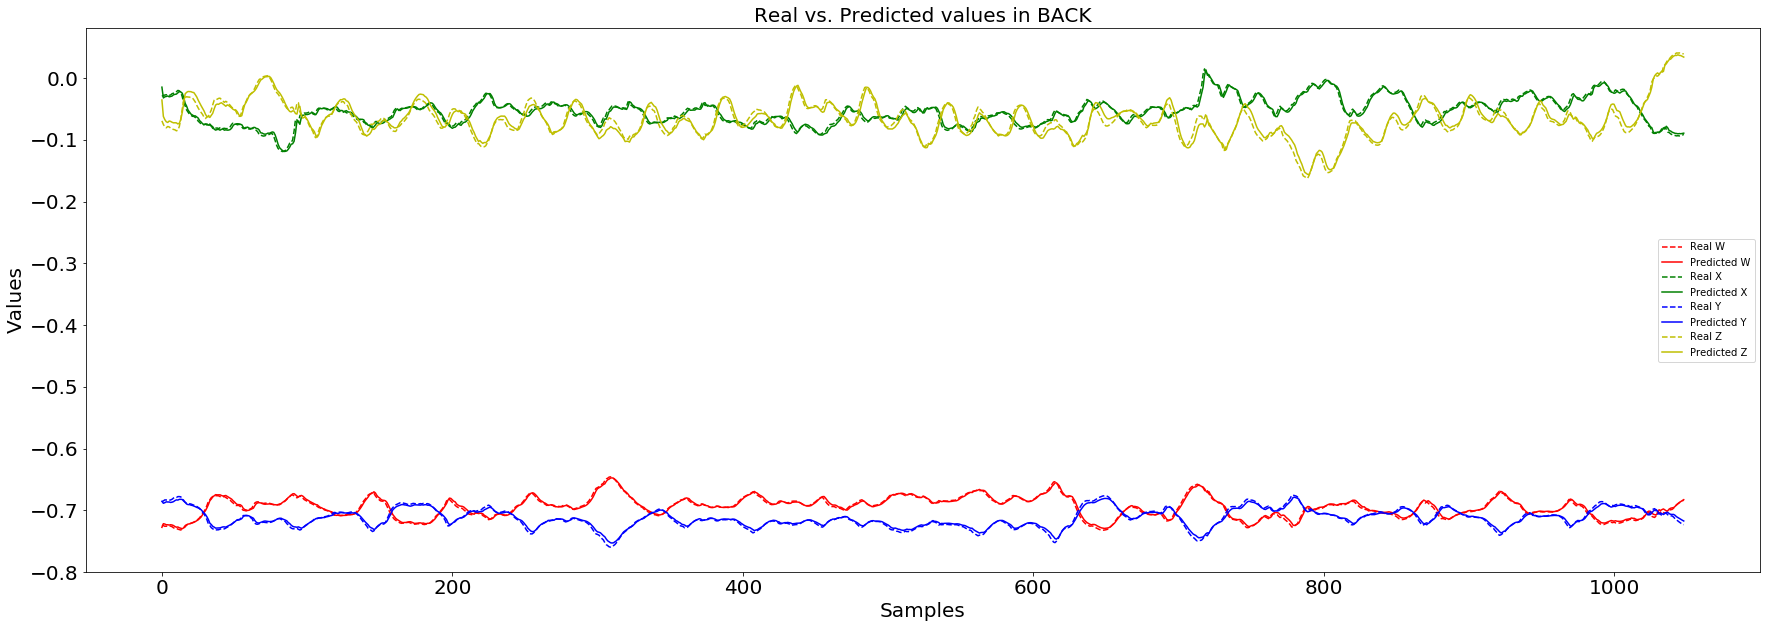

<Figure size 432x288 with 0 Axes>

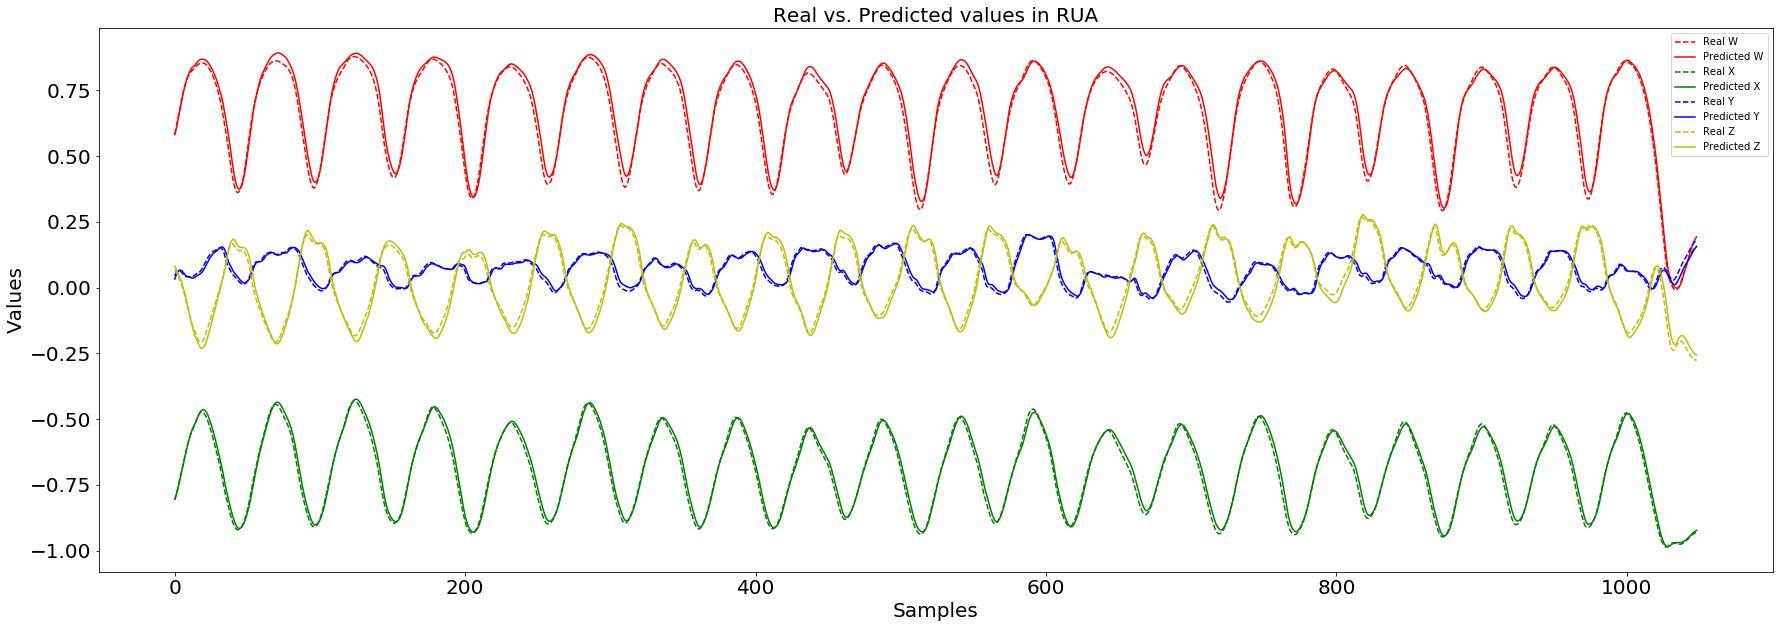

<Figure size 432x288 with 0 Axes>

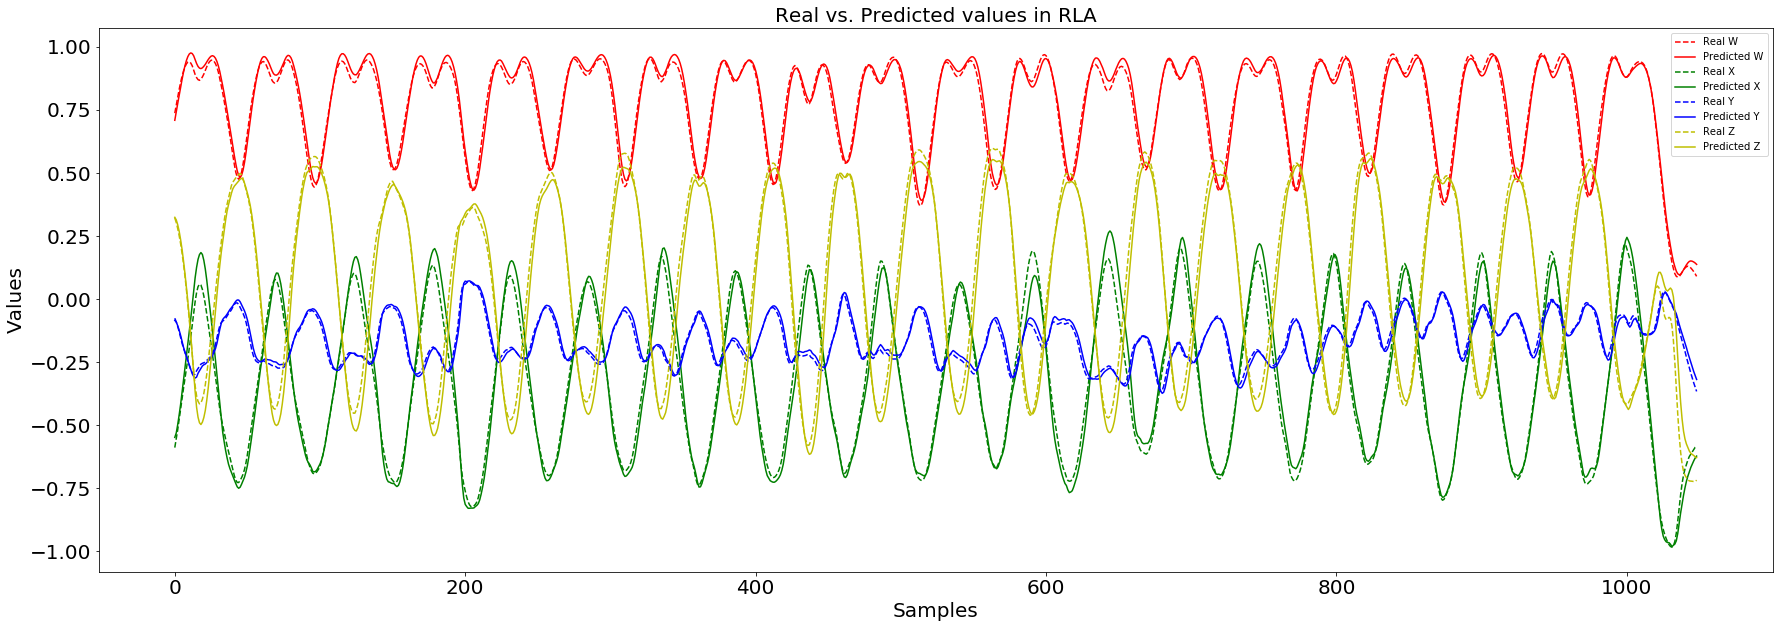

<Figure size 432x288 with 0 Axes>

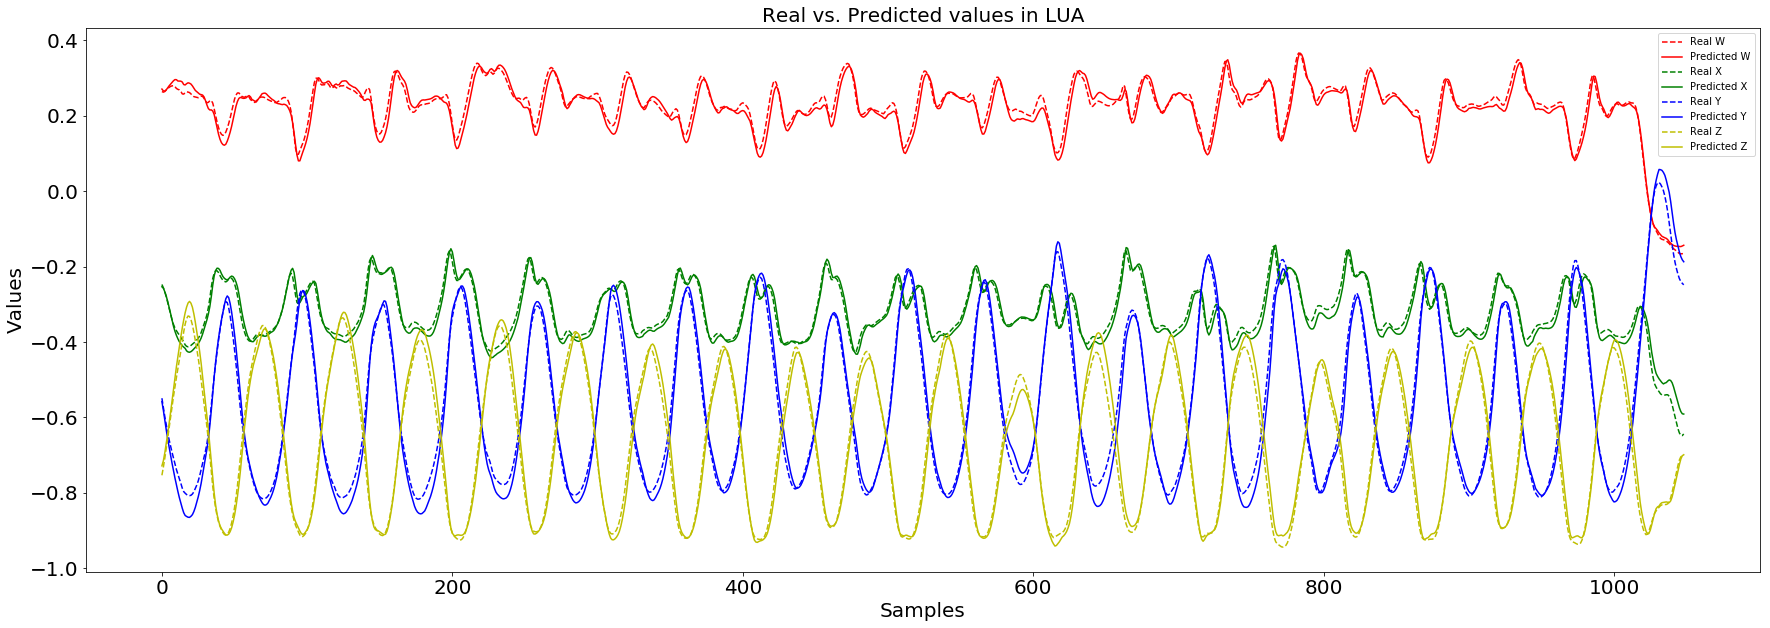

<Figure size 432x288 with 0 Axes>

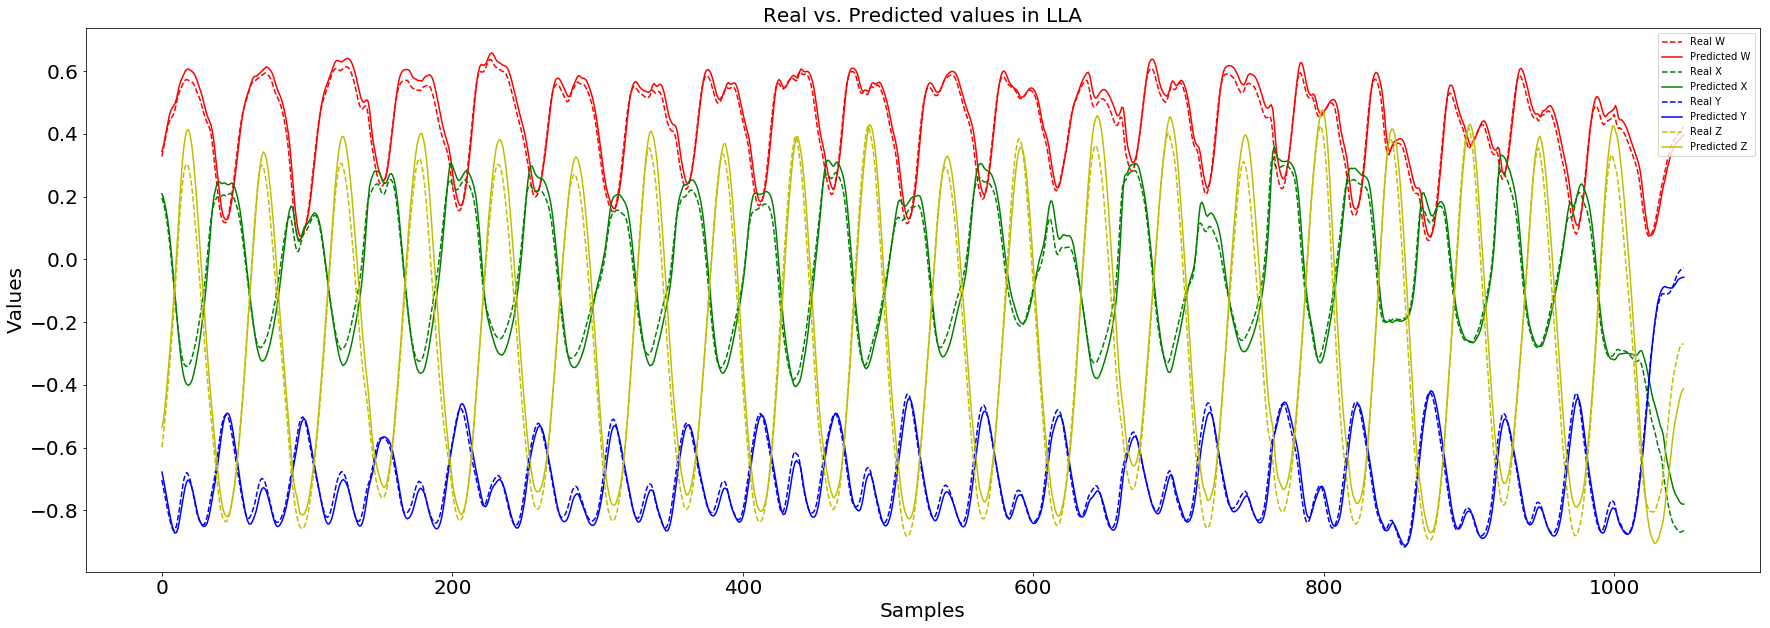

In [43]:
name = 'RESULT'
plot_results(testY,testPredict,name)

In [44]:
model.save('./00_06z_models/predict_rnn.h5')
print('RNN saved.')

RNN saved.
